In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
from scipy.io import wavfile
import scipy.signal as sps
from io import BytesIO

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    return wav

In [4]:
cleanTrain = os.path.join('data', 'clean_train')
cleanTest = os.path.join('data', 'clean_test')
noiseTrain = os.path.join('data', 'noise_train')
noiseTest = os.path.join('data', 'noise_test')

In [4]:
clean = tf.data.Dataset.list_files(cleanTrain+'/*.wav')
noise = tf.data.Dataset.list_files(noiseTrain+'/*.wav')  
cleanVal = tf.data.Dataset.list_files(cleanTest+'/*.wav')
noiseVal = tf.data.Dataset.list_files(noiseTest+'/*.wav')

Metal device set to: Apple M1 Pro


2022-08-01 14:38:40.708773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 14:38:40.708877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
one = tf.data.Dataset.zip((clean, tf.data.Dataset.from_tensor_slices(tf.ones(len(clean)))))
zero = tf.data.Dataset.zip((noise, tf.data.Dataset.from_tensor_slices(tf.zeros(len(noise)))))
data = zero.concatenate(one)

In [6]:
oneVal = tf.data.Dataset.zip((cleanVal, tf.data.Dataset.from_tensor_slices(tf.ones(len(cleanVal)))))
zeroVal = tf.data.Dataset.zip((noiseVal, tf.data.Dataset.from_tensor_slices(tf.zeros(len(noiseVal)))))
test = zeroVal.concatenate(oneVal)

In [7]:
list(data.shuffle(1000000).as_numpy_iterator())

[(b'data/clean_train/p249_217.wav', 1.0),
 (b'data/clean_train/p295_092.wav', 1.0),
 (b'data/clean_train/p234_190.wav', 1.0),
 (b'data/clean_train/p237_150.wav', 1.0),
 (b'data/clean_train/p275_223.wav', 1.0),
 (b'data/clean_train/p298_154.wav', 1.0),
 (b'data/clean_train/p343_291.wav', 1.0),
 (b'data/clean_train/p251_361.wav', 1.0),
 (b'data/clean_train/p241_225.wav', 1.0),
 (b'data/clean_train/p304_308.wav', 1.0),
 (b'data/clean_train/p336_254.wav', 1.0),
 (b'data/clean_train/p316_121.wav', 1.0),
 (b'data/clean_train/p314_044.wav', 1.0),
 (b'data/clean_train/p374_001.wav', 1.0),
 (b'data/clean_train/p308_040.wav', 1.0),
 (b'data/clean_train/p376_016.wav', 1.0),
 (b'data/clean_train/p266_170.wav', 1.0),
 (b'data/clean_train/p351_371.wav', 1.0),
 (b'data/clean_train/p234_235.wav', 1.0),
 (b'data/clean_train/p281_027.wav', 1.0),
 (b'data/clean_train/p308_116.wav', 1.0),
 (b'data/clean_train/p335_032.wav', 1.0),
 (b'data/clean_train/p260_122.wav', 1.0),
 (b'data/clean_train/p361_415.wav'

In [8]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

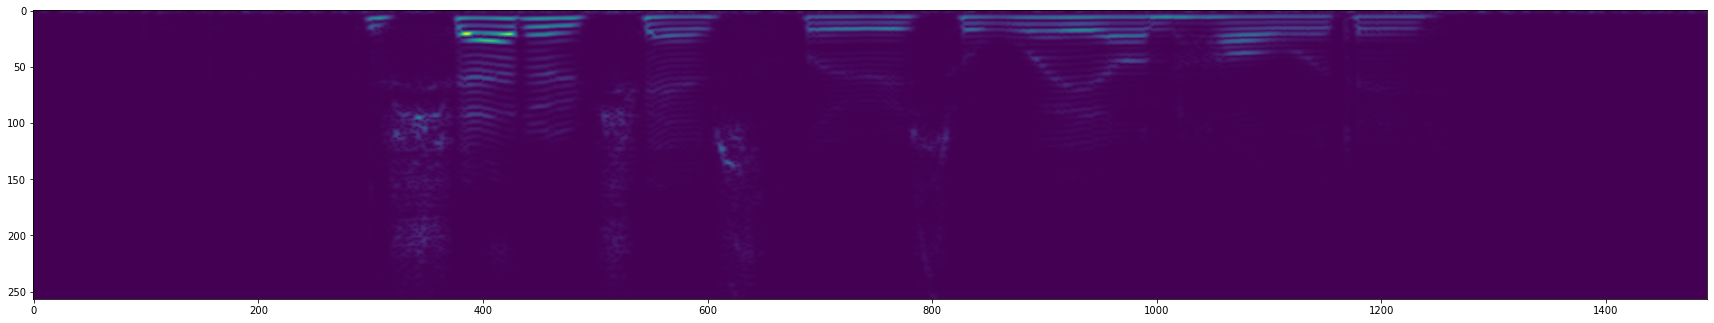

In [9]:
filepath, label = one.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [10]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [11]:
test = test.map(preprocess)
test = test.cache()
test = test.shuffle(buffer_size=1000)
test = test.batch(16)
test = test.prefetch(8)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [13]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [1]:
hist = model.fit(data, epochs=4, validation_data=test)

NameError: name 'model' is not defined